## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
!pip3 install torch==1.10.1+cu102 torchvision==0.11.2+cu102 torchaudio===0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install torchsummary

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [9]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 300),
            nn.BatchNorm1d(300),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 300]         153,900
       BatchNorm1d-5                  [-1, 300]             600
            Linear-6                  [-1, 150]          45,150
              ReLU-7                  [-1, 150]               0
            Linear-8                   [-1, 64]           9,664
       BatchNorm1d-9                   [-1, 64]             128
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 612,012
Trainable params: 612,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

Your experiments come here:

In [11]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001) 
loss_func = nn.CrossEntropyLoss() 

In [12]:
from tqdm import tqdm

total_step = len(train_loader)

epochs = 20

losses = []
accuracies = []

for ep in tqdm(range(1, epochs + 1)):
    for i, (images, labels) in enumerate(train_loader):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 50 == 0:
            print ("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                   .format(ep, epochs, i, total_step, loss.item()))
    
    losses.append(loss.item())
    
    with torch.no_grad():
        real_acc = 0.0
        new_size = 0.0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs.data, 1)
            new_size += labels.size(0)
            real_acc += (pred == labels).sum().item()

        accuracy = 100 * real_acc / new_size
        accuracies.append(accuracy)
        
        print ('Epoch [{}/{}], \t Accuracy {}%'.format(ep, epochs, accuracy))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Step [0/469], Loss: 2.3167
Epoch [1/20], Step [50/469], Loss: 0.7519
Epoch [1/20], Step [100/469], Loss: 0.4729
Epoch [1/20], Step [150/469], Loss: 0.5037
Epoch [1/20], Step [200/469], Loss: 0.5918
Epoch [1/20], Step [250/469], Loss: 0.3840
Epoch [1/20], Step [300/469], Loss: 0.3286
Epoch [1/20], Step [350/469], Loss: 0.3609
Epoch [1/20], Step [400/469], Loss: 0.3747
Epoch [1/20], Step [450/469], Loss: 0.2981


  5%|████▏                                                                              | 1/20 [00:27<08:48, 27.80s/it]

Epoch [1/20], 	 Accuracy 84.38%
Epoch [2/20], Step [0/469], Loss: 0.5509
Epoch [2/20], Step [50/469], Loss: 0.4734
Epoch [2/20], Step [100/469], Loss: 0.3439
Epoch [2/20], Step [150/469], Loss: 0.3726
Epoch [2/20], Step [200/469], Loss: 0.3175
Epoch [2/20], Step [250/469], Loss: 0.3705
Epoch [2/20], Step [300/469], Loss: 0.3089
Epoch [2/20], Step [350/469], Loss: 0.2769
Epoch [2/20], Step [400/469], Loss: 0.2264
Epoch [2/20], Step [450/469], Loss: 0.3215


 10%|████████▎                                                                          | 2/20 [00:55<08:17, 27.62s/it]

Epoch [2/20], 	 Accuracy 86.49%
Epoch [3/20], Step [0/469], Loss: 0.2776
Epoch [3/20], Step [50/469], Loss: 0.3561
Epoch [3/20], Step [100/469], Loss: 0.3979
Epoch [3/20], Step [150/469], Loss: 0.3175
Epoch [3/20], Step [200/469], Loss: 0.3290
Epoch [3/20], Step [250/469], Loss: 0.2043
Epoch [3/20], Step [300/469], Loss: 0.3258
Epoch [3/20], Step [350/469], Loss: 0.3305
Epoch [3/20], Step [400/469], Loss: 0.4653
Epoch [3/20], Step [450/469], Loss: 0.2352


 15%|████████████▍                                                                      | 3/20 [01:23<07:50, 27.68s/it]

Epoch [3/20], 	 Accuracy 86.72%
Epoch [4/20], Step [0/469], Loss: 0.3959
Epoch [4/20], Step [50/469], Loss: 0.3205
Epoch [4/20], Step [100/469], Loss: 0.2785
Epoch [4/20], Step [150/469], Loss: 0.3333
Epoch [4/20], Step [200/469], Loss: 0.2363
Epoch [4/20], Step [250/469], Loss: 0.4028
Epoch [4/20], Step [300/469], Loss: 0.2474
Epoch [4/20], Step [350/469], Loss: 0.4490
Epoch [4/20], Step [400/469], Loss: 0.3146
Epoch [4/20], Step [450/469], Loss: 0.3240


 20%|████████████████▌                                                                  | 4/20 [01:50<07:23, 27.72s/it]

Epoch [4/20], 	 Accuracy 87.44%
Epoch [5/20], Step [0/469], Loss: 0.2378
Epoch [5/20], Step [50/469], Loss: 0.2992
Epoch [5/20], Step [100/469], Loss: 0.1635
Epoch [5/20], Step [150/469], Loss: 0.4096
Epoch [5/20], Step [200/469], Loss: 0.3263
Epoch [5/20], Step [250/469], Loss: 0.2922
Epoch [5/20], Step [300/469], Loss: 0.3329
Epoch [5/20], Step [350/469], Loss: 0.3061
Epoch [5/20], Step [400/469], Loss: 0.2760
Epoch [5/20], Step [450/469], Loss: 0.3001


 25%|████████████████████▊                                                              | 5/20 [02:20<07:06, 28.47s/it]

Epoch [5/20], 	 Accuracy 87.49%
Epoch [6/20], Step [0/469], Loss: 0.2432
Epoch [6/20], Step [50/469], Loss: 0.2523
Epoch [6/20], Step [100/469], Loss: 0.2179
Epoch [6/20], Step [150/469], Loss: 0.2098
Epoch [6/20], Step [200/469], Loss: 0.2703
Epoch [6/20], Step [250/469], Loss: 0.2618
Epoch [6/20], Step [300/469], Loss: 0.3228
Epoch [6/20], Step [350/469], Loss: 0.3158
Epoch [6/20], Step [400/469], Loss: 0.3352
Epoch [6/20], Step [450/469], Loss: 0.3219


 30%|████████████████████████▉                                                          | 6/20 [02:49<06:41, 28.67s/it]

Epoch [6/20], 	 Accuracy 87.56%
Epoch [7/20], Step [0/469], Loss: 0.2265
Epoch [7/20], Step [50/469], Loss: 0.2513
Epoch [7/20], Step [100/469], Loss: 0.2350
Epoch [7/20], Step [150/469], Loss: 0.2071
Epoch [7/20], Step [200/469], Loss: 0.2592
Epoch [7/20], Step [250/469], Loss: 0.2932
Epoch [7/20], Step [300/469], Loss: 0.2185
Epoch [7/20], Step [350/469], Loss: 0.2023
Epoch [7/20], Step [400/469], Loss: 0.2454
Epoch [7/20], Step [450/469], Loss: 0.1954


 35%|█████████████████████████████                                                      | 7/20 [03:20<06:19, 29.22s/it]

Epoch [7/20], 	 Accuracy 87.99%
Epoch [8/20], Step [0/469], Loss: 0.2350
Epoch [8/20], Step [50/469], Loss: 0.2763
Epoch [8/20], Step [100/469], Loss: 0.2435
Epoch [8/20], Step [150/469], Loss: 0.1934
Epoch [8/20], Step [200/469], Loss: 0.3107
Epoch [8/20], Step [250/469], Loss: 0.2540
Epoch [8/20], Step [300/469], Loss: 0.1658
Epoch [8/20], Step [350/469], Loss: 0.3364
Epoch [8/20], Step [400/469], Loss: 0.2592
Epoch [8/20], Step [450/469], Loss: 0.2231


 40%|█████████████████████████████████▏                                                 | 8/20 [03:53<06:06, 30.53s/it]

Epoch [8/20], 	 Accuracy 88.34%
Epoch [9/20], Step [0/469], Loss: 0.2002
Epoch [9/20], Step [50/469], Loss: 0.3202
Epoch [9/20], Step [100/469], Loss: 0.2396
Epoch [9/20], Step [150/469], Loss: 0.2673
Epoch [9/20], Step [200/469], Loss: 0.2858
Epoch [9/20], Step [250/469], Loss: 0.2703
Epoch [9/20], Step [300/469], Loss: 0.2129
Epoch [9/20], Step [350/469], Loss: 0.2755
Epoch [9/20], Step [400/469], Loss: 0.3339
Epoch [9/20], Step [450/469], Loss: 0.2962


 45%|█████████████████████████████████████▎                                             | 9/20 [04:22<05:29, 29.96s/it]

Epoch [9/20], 	 Accuracy 88.8%
Epoch [10/20], Step [0/469], Loss: 0.2456
Epoch [10/20], Step [50/469], Loss: 0.1786
Epoch [10/20], Step [100/469], Loss: 0.2748
Epoch [10/20], Step [150/469], Loss: 0.2348
Epoch [10/20], Step [200/469], Loss: 0.2720
Epoch [10/20], Step [250/469], Loss: 0.1635
Epoch [10/20], Step [300/469], Loss: 0.3139
Epoch [10/20], Step [350/469], Loss: 0.2544
Epoch [10/20], Step [400/469], Loss: 0.1460
Epoch [10/20], Step [450/469], Loss: 0.2208


 50%|█████████████████████████████████████████                                         | 10/20 [04:50<04:54, 29.49s/it]

Epoch [10/20], 	 Accuracy 88.8%
Epoch [11/20], Step [0/469], Loss: 0.3203
Epoch [11/20], Step [50/469], Loss: 0.2303
Epoch [11/20], Step [100/469], Loss: 0.2652
Epoch [11/20], Step [150/469], Loss: 0.2741
Epoch [11/20], Step [200/469], Loss: 0.1746
Epoch [11/20], Step [250/469], Loss: 0.2378
Epoch [11/20], Step [300/469], Loss: 0.1925
Epoch [11/20], Step [350/469], Loss: 0.1904
Epoch [11/20], Step [400/469], Loss: 0.1836
Epoch [11/20], Step [450/469], Loss: 0.2007


 55%|█████████████████████████████████████████████                                     | 11/20 [05:19<04:22, 29.20s/it]

Epoch [11/20], 	 Accuracy 88.48%
Epoch [12/20], Step [0/469], Loss: 0.1723
Epoch [12/20], Step [50/469], Loss: 0.2260
Epoch [12/20], Step [100/469], Loss: 0.2481
Epoch [12/20], Step [150/469], Loss: 0.1990
Epoch [12/20], Step [200/469], Loss: 0.1128
Epoch [12/20], Step [250/469], Loss: 0.1824
Epoch [12/20], Step [300/469], Loss: 0.1737
Epoch [12/20], Step [350/469], Loss: 0.1889
Epoch [12/20], Step [400/469], Loss: 0.2268
Epoch [12/20], Step [450/469], Loss: 0.2864


 60%|█████████████████████████████████████████████████▏                                | 12/20 [05:47<03:50, 28.85s/it]

Epoch [12/20], 	 Accuracy 89.15%
Epoch [13/20], Step [0/469], Loss: 0.1305
Epoch [13/20], Step [50/469], Loss: 0.1993
Epoch [13/20], Step [100/469], Loss: 0.2605
Epoch [13/20], Step [150/469], Loss: 0.1532
Epoch [13/20], Step [200/469], Loss: 0.2697
Epoch [13/20], Step [250/469], Loss: 0.1838
Epoch [13/20], Step [300/469], Loss: 0.2721
Epoch [13/20], Step [350/469], Loss: 0.2816
Epoch [13/20], Step [400/469], Loss: 0.2621
Epoch [13/20], Step [450/469], Loss: 0.1947


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [06:14<03:18, 28.41s/it]

Epoch [13/20], 	 Accuracy 89.08%
Epoch [14/20], Step [0/469], Loss: 0.1739
Epoch [14/20], Step [50/469], Loss: 0.1650
Epoch [14/20], Step [100/469], Loss: 0.1317
Epoch [14/20], Step [150/469], Loss: 0.2606
Epoch [14/20], Step [200/469], Loss: 0.2355
Epoch [14/20], Step [250/469], Loss: 0.1906
Epoch [14/20], Step [300/469], Loss: 0.1487
Epoch [14/20], Step [350/469], Loss: 0.1843
Epoch [14/20], Step [400/469], Loss: 0.1321
Epoch [14/20], Step [450/469], Loss: 0.2367


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [06:42<02:50, 28.39s/it]

Epoch [14/20], 	 Accuracy 88.64%
Epoch [15/20], Step [0/469], Loss: 0.1412
Epoch [15/20], Step [50/469], Loss: 0.2125
Epoch [15/20], Step [100/469], Loss: 0.2793
Epoch [15/20], Step [150/469], Loss: 0.1895
Epoch [15/20], Step [200/469], Loss: 0.1934
Epoch [15/20], Step [250/469], Loss: 0.1156
Epoch [15/20], Step [300/469], Loss: 0.1593
Epoch [15/20], Step [350/469], Loss: 0.1784
Epoch [15/20], Step [400/469], Loss: 0.1414
Epoch [15/20], Step [450/469], Loss: 0.2969


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [07:10<02:20, 28.17s/it]

Epoch [15/20], 	 Accuracy 88.79%
Epoch [16/20], Step [0/469], Loss: 0.1703
Epoch [16/20], Step [50/469], Loss: 0.1837
Epoch [16/20], Step [100/469], Loss: 0.1966
Epoch [16/20], Step [150/469], Loss: 0.0982
Epoch [16/20], Step [200/469], Loss: 0.1509
Epoch [16/20], Step [250/469], Loss: 0.1934
Epoch [16/20], Step [300/469], Loss: 0.2095
Epoch [16/20], Step [350/469], Loss: 0.1908
Epoch [16/20], Step [400/469], Loss: 0.1130
Epoch [16/20], Step [450/469], Loss: 0.1702


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [07:38<01:53, 28.25s/it]

Epoch [16/20], 	 Accuracy 89.19%
Epoch [17/20], Step [0/469], Loss: 0.1682
Epoch [17/20], Step [50/469], Loss: 0.2029
Epoch [17/20], Step [100/469], Loss: 0.1873
Epoch [17/20], Step [150/469], Loss: 0.1663
Epoch [17/20], Step [200/469], Loss: 0.1437
Epoch [17/20], Step [250/469], Loss: 0.2909
Epoch [17/20], Step [300/469], Loss: 0.2821
Epoch [17/20], Step [350/469], Loss: 0.2043
Epoch [17/20], Step [400/469], Loss: 0.1536
Epoch [17/20], Step [450/469], Loss: 0.2418


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [08:06<01:24, 28.04s/it]

Epoch [17/20], 	 Accuracy 89.38%
Epoch [18/20], Step [0/469], Loss: 0.1303
Epoch [18/20], Step [50/469], Loss: 0.1743
Epoch [18/20], Step [100/469], Loss: 0.1404
Epoch [18/20], Step [150/469], Loss: 0.1623
Epoch [18/20], Step [200/469], Loss: 0.1625
Epoch [18/20], Step [250/469], Loss: 0.1461
Epoch [18/20], Step [300/469], Loss: 0.2412
Epoch [18/20], Step [350/469], Loss: 0.1484
Epoch [18/20], Step [400/469], Loss: 0.2105
Epoch [18/20], Step [450/469], Loss: 0.2681


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [08:34<00:55, 27.90s/it]

Epoch [18/20], 	 Accuracy 88.84%
Epoch [19/20], Step [0/469], Loss: 0.1461
Epoch [19/20], Step [50/469], Loss: 0.2075
Epoch [19/20], Step [100/469], Loss: 0.1361
Epoch [19/20], Step [150/469], Loss: 0.1151
Epoch [19/20], Step [200/469], Loss: 0.1861
Epoch [19/20], Step [250/469], Loss: 0.1857
Epoch [19/20], Step [300/469], Loss: 0.2473
Epoch [19/20], Step [350/469], Loss: 0.1431
Epoch [19/20], Step [400/469], Loss: 0.1776
Epoch [19/20], Step [450/469], Loss: 0.1409


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [09:03<00:28, 28.22s/it]

Epoch [19/20], 	 Accuracy 89.15%
Epoch [20/20], Step [0/469], Loss: 0.2118
Epoch [20/20], Step [50/469], Loss: 0.2043
Epoch [20/20], Step [100/469], Loss: 0.1609
Epoch [20/20], Step [150/469], Loss: 0.2267
Epoch [20/20], Step [200/469], Loss: 0.1510
Epoch [20/20], Step [250/469], Loss: 0.1788
Epoch [20/20], Step [300/469], Loss: 0.1212
Epoch [20/20], Step [350/469], Loss: 0.1979
Epoch [20/20], Step [400/469], Loss: 0.1783
Epoch [20/20], Step [450/469], Loss: 0.1733


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:31<00:00, 28.55s/it]

Epoch [20/20], 	 Accuracy 88.79%


In [16]:
print("Total accuracy: " + str(accuracies[-1]))

Total accuracy: 88.79


Нарисуем, что получилось:

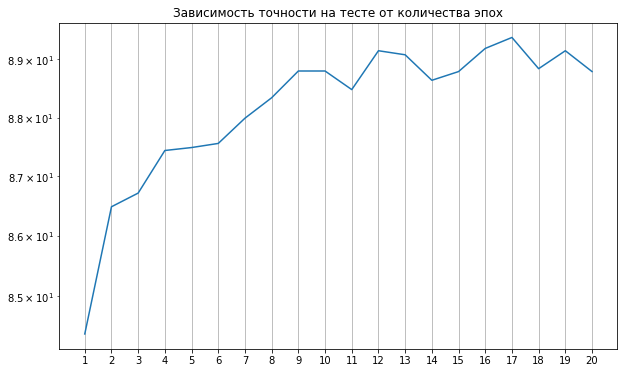

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracies)
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.yscale('log')
plt.title("Зависимость точности на тесте от количества эпох")
plt.grid()

Видим, что с увеличением количества эпох увеличивается качество.

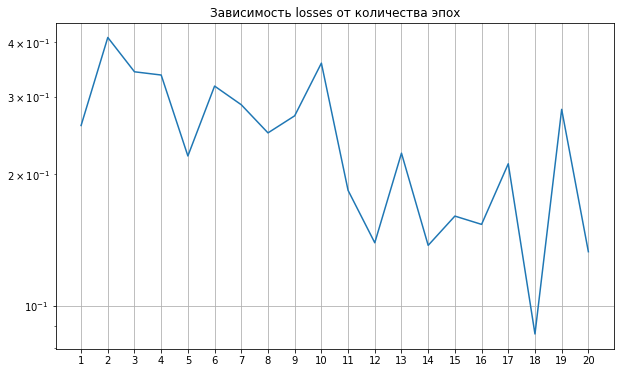

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses)
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.yscale('log')
plt.title("Зависимость losses от количества эпох")
plt.grid()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [24]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 300),
            nn.BatchNorm1d(300),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [25]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 300]         153,900
       BatchNorm1d-5                  [-1, 300]             600
            Linear-6                  [-1, 150]          45,150
              ReLU-7                  [-1, 150]               0
            Linear-8                   [-1, 64]           9,664
       BatchNorm1d-9                   [-1, 64]             128
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 612,012
Trainable params: 612,012
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [29]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [30]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=256,
                                           shuffle=False,
                                           num_workers=2,)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [34]:
stop_index = 1

total_step = len(train_loader)

epochs = 30

accuracy_train = []
accuracy_test = []
losses_train = []
losses_test = []

for ep in tqdm(range(1, epochs + 1)):
    for i, (images, labels) in enumerate(train_loader):  
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    # train acc
    with torch.no_grad():
        real_acc = 0.0
        new_size = 0.0
        for j, (images, labels) in enumerate(train_loader):
            if j < stop_index:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                this_loss = loss_function(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                new_size += labels.size(0)
                real_acc += (pred == labels).sum().item()

        train_acc = 100 * real_acc / new_size
        accuracy_train.append(train_acc)
        losses_train.append(this_loss.item())
    
    # test acc
    with torch.no_grad():
        real_acc = 0.0
        new_size = 0.0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            this_loss = loss_function(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            new_size += labels.size(0)
            real_acc += (pred == labels).sum().item()

        test_acc = 100 * real_acc / new_size
        accuracy_test.append(test_acc)
        losses_test.append(this_loss.item())
        
    print ('Epoch [{}/{}], \t Train accuracy {}%'.format(ep, epochs, train_acc))
    print ('Epoch [{}/{}], \t Test accuracy {}%'.format(ep, epochs, test_acc))

  3%|██▊                                                                                | 1/30 [00:38<18:43, 38.74s/it]

Epoch [1/30], 	 Train accuracy 90.83757364756293%
Epoch [1/30], 	 Test accuracy 88.2%


  7%|█████▌                                                                             | 2/30 [01:17<18:04, 38.74s/it]

Epoch [2/30], 	 Train accuracy 91.31460899839314%
Epoch [2/30], 	 Test accuracy 87.88%


 10%|████████▎                                                                          | 3/30 [01:55<17:17, 38.43s/it]

Epoch [3/30], 	 Train accuracy 91.67949919657204%
Epoch [3/30], 	 Test accuracy 88.14%


 13%|███████████                                                                        | 4/30 [02:35<16:56, 39.11s/it]

Epoch [4/30], 	 Train accuracy 91.9305704338511%
Epoch [4/30], 	 Test accuracy 88.3%


 17%|█████████████▊                                                                     | 5/30 [03:17<16:40, 40.00s/it]

Epoch [5/30], 	 Train accuracy 92.14983931440814%
Epoch [5/30], 	 Test accuracy 88.18%


 20%|████████████████▌                                                                  | 6/30 [03:56<15:55, 39.83s/it]

Epoch [6/30], 	 Train accuracy 92.41597482592394%
Epoch [6/30], 	 Test accuracy 88.21%


 23%|███████████████████▎                                                               | 7/30 [04:35<15:10, 39.59s/it]

Epoch [7/30], 	 Train accuracy 92.59841992501339%
Epoch [7/30], 	 Test accuracy 88.42%


 27%|██████████████████████▏                                                            | 8/30 [05:13<14:20, 39.12s/it]

Epoch [8/30], 	 Train accuracy 92.88798875200857%
Epoch [8/30], 	 Test accuracy 88.46%


 30%|████████████████████████▉                                                          | 9/30 [05:52<13:40, 39.07s/it]

Epoch [9/30], 	 Train accuracy 93.06039100160686%
Epoch [9/30], 	 Test accuracy 88.52%


 33%|███████████████████████████▎                                                      | 10/30 [06:30<12:51, 38.57s/it]

Epoch [10/30], 	 Train accuracy 93.18760042849492%
Epoch [10/30], 	 Test accuracy 88.52%


 37%|██████████████████████████████                                                    | 11/30 [07:08<12:10, 38.46s/it]

Epoch [11/30], 	 Train accuracy 93.04532672737011%
Epoch [11/30], 	 Test accuracy 88.7%


 40%|████████████████████████████████▊                                                 | 12/30 [07:46<11:29, 38.33s/it]

Epoch [12/30], 	 Train accuracy 92.81099357257632%
Epoch [12/30], 	 Test accuracy 87.93%


 43%|███████████████████████████████████▌                                              | 13/30 [08:24<10:48, 38.14s/it]

Epoch [13/30], 	 Train accuracy 93.24116229244778%
Epoch [13/30], 	 Test accuracy 88.24%


 47%|██████████████████████████████████████▎                                           | 14/30 [09:01<10:07, 37.94s/it]

Epoch [14/30], 	 Train accuracy 93.41189073379753%
Epoch [14/30], 	 Test accuracy 88.35%


 50%|█████████████████████████████████████████                                         | 15/30 [09:40<09:33, 38.21s/it]

Epoch [15/30], 	 Train accuracy 93.18257900374932%
Epoch [15/30], 	 Test accuracy 88.04%


 53%|███████████████████████████████████████████▋                                      | 16/30 [10:19<08:56, 38.33s/it]

Epoch [16/30], 	 Train accuracy 93.48721210498125%
Epoch [16/30], 	 Test accuracy 88.05%


 57%|██████████████████████████████████████████████▍                                   | 17/30 [10:57<08:16, 38.20s/it]

Epoch [17/30], 	 Train accuracy 93.46043117300482%
Epoch [17/30], 	 Test accuracy 88.39%


 60%|█████████████████████████████████████████████████▏                                | 18/30 [11:35<07:37, 38.15s/it]

Epoch [18/30], 	 Train accuracy 93.63115961435457%
Epoch [18/30], 	 Test accuracy 88.4%


 63%|███████████████████████████████████████████████████▉                              | 19/30 [12:14<07:02, 38.40s/it]

Epoch [19/30], 	 Train accuracy 93.52738350294591%
Epoch [19/30], 	 Test accuracy 88.33%


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [12:53<06:25, 38.54s/it]

Epoch [20/30], 	 Train accuracy 94.01780931976432%
Epoch [20/30], 	 Test accuracy 88.26%


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [13:30<05:44, 38.26s/it]

Epoch [21/30], 	 Train accuracy 93.88055704338511%
Epoch [21/30], 	 Test accuracy 88.01%


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [14:08<05:05, 38.20s/it]

Epoch [22/30], 	 Train accuracy 93.95755222281736%
Epoch [22/30], 	 Test accuracy 88.33%


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [14:47<04:27, 38.27s/it]

Epoch [23/30], 	 Train accuracy 94.27222817354044%
Epoch [23/30], 	 Test accuracy 88.27%


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [15:26<03:50, 38.46s/it]

Epoch [24/30], 	 Train accuracy 94.43458757364756%
Epoch [24/30], 	 Test accuracy 88.39%


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [16:04<03:12, 38.44s/it]

Epoch [25/30], 	 Train accuracy 94.35424477771826%
Epoch [25/30], 	 Test accuracy 87.95%


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [16:43<02:34, 38.58s/it]

Epoch [26/30], 	 Train accuracy 94.54338510980182%
Epoch [26/30], 	 Test accuracy 87.97%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [17:22<01:55, 38.61s/it]

Epoch [27/30], 	 Train accuracy 94.6036422067488%
Epoch [27/30], 	 Test accuracy 88.37%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [18:00<01:17, 38.52s/it]

Epoch [28/30], 	 Train accuracy 94.74926352437065%
Epoch [28/30], 	 Test accuracy 88.19%


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [18:38<00:38, 38.39s/it]

Epoch [29/30], 	 Train accuracy 94.3257900374933%
Epoch [29/30], 	 Test accuracy 87.68%


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [19:20<00:00, 38.68s/it]

Epoch [30/30], 	 Train accuracy 95.01707284413497%
Epoch [30/30], 	 Test accuracy 88.28%


In [35]:
print("Final accuracy on train: " + str(accuracy_train[-1]))
print("Final accuracy on test: " + str(accuracy_test[-1]))

Final accuracy on train: 95.01707284413497
Final accuracy on test: 88.28


Посмотрим визуально, как менялись losses и accuracies:

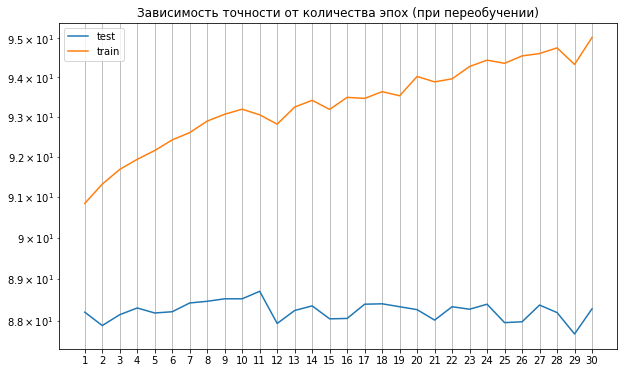

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_test, label='test')
plt.plot(range(1, epochs + 1), accuracy_train, label='train')
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.yscale('log')
plt.legend()
plt.title("Зависимость точности от количества эпох (при переобучении)")
plt.grid()

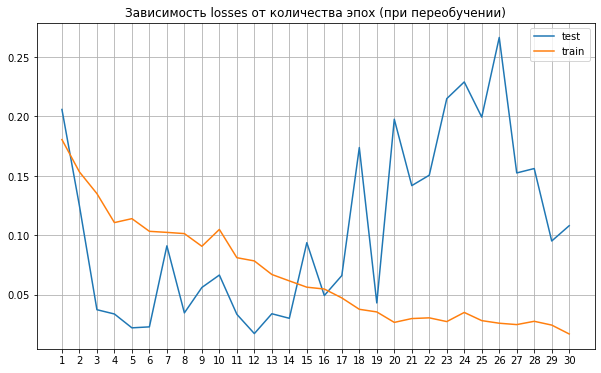

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses_test, label='test')
plt.plot(range(1, epochs + 1), losses_train, label='train')
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.legend()
plt.title("Зависимость losses от количества эпох (при переобучении)")
plt.grid()

Видим, что происходит переобучение - с train все в порядке. Растет качество и уменьшается loss.

С test происходит что-то непонятное, нет никакой сходимости.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Т.к. изначально в структуре был Batchnorm, будем использовать Dropout, чтобы избежать overfitting'a. 

In [7]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 300),
            nn.BatchNorm1d(300),
            nn.Dropout(p=.35, inplace=False),
            nn.Linear(300, 150),
            nn.ReLU(),
            nn.Linear(150, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(p=.23, inplace=False),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 300]         153,900
       BatchNorm1d-5                  [-1, 300]             600
           Dropout-6                  [-1, 300]               0
            Linear-7                  [-1, 150]          45,150
              ReLU-8                  [-1, 150]               0
            Linear-9                   [-1, 64]           9,664
      BatchNorm1d-10                   [-1, 64]             128
          Dropout-11                   [-1, 64]               0
             ReLU-12                   [-1, 64]               0
           Linear-13                   [-1, 10]             650
Total params: 612,012
Trainable params:

In [13]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [14]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=2048,
                                           shuffle=False,
                                           num_workers=2,)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [15]:
from tqdm import tqdm

stop_index = 300

total_step = len(train_loader)

epochs = 10

accuracy_train = []
accuracy_test = []
losses_train = []
losses_test = []

for ep in tqdm(range(1, epochs + 1)):
    for j, (images, labels) in enumerate(train_loader):  
        
        if j < stop_index:
        
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()
    
    # train acc
    with torch.no_grad():
        real_acc = 0.0
        new_size = 0.0
        for j, (images, labels) in enumerate(train_loader):
            if j < stop_index:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                this_loss = loss_function(outputs, labels)
                _, pred = torch.max(outputs.data, 1)
                new_size += labels.size(0)
                real_acc += (pred == labels).sum().item()

        train_acc = 100 * real_acc / new_size
        accuracy_train.append(train_acc)
        losses_train.append(this_loss.item())
    
    # test acc
    with torch.no_grad():
        real_acc = 0.0
        new_size = 0.0
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            this_loss = loss_function(outputs, labels)
            _, pred = torch.max(outputs.data, 1)
            new_size += labels.size(0)
            real_acc += (pred == labels).sum().item()

        test_acc = 100 * real_acc / new_size
        accuracy_test.append(test_acc)
        losses_test.append(this_loss.item())
        
    print ('Epoch [{}/{}], \t Train accuracy {}%'.format(ep, epochs, train_acc))
    print ('Epoch [{}/{}], \t Test accuracy {}%'.format(ep, epochs, test_acc))

 10%|████████▎                                                                          | 1/10 [00:24<03:43, 24.87s/it]

Epoch [1/10], 	 Train accuracy 81.945%
Epoch [1/10], 	 Test accuracy 80.37%


 20%|████████████████▌                                                                  | 2/10 [00:49<03:17, 24.73s/it]

Epoch [2/10], 	 Train accuracy 86.32%
Epoch [2/10], 	 Test accuracy 84.61%


 30%|████████████████████████▉                                                          | 3/10 [01:13<02:49, 24.17s/it]

Epoch [3/10], 	 Train accuracy 87.745%
Epoch [3/10], 	 Test accuracy 85.61%


 40%|█████████████████████████████████▏                                                 | 4/10 [01:39<02:29, 24.94s/it]

Epoch [4/10], 	 Train accuracy 88.42333333333333%
Epoch [4/10], 	 Test accuracy 86.29%


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:09<02:15, 27.01s/it]

Epoch [5/10], 	 Train accuracy 88.76%
Epoch [5/10], 	 Test accuracy 86.51%


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:39<01:52, 28.05s/it]

Epoch [6/10], 	 Train accuracy 89.65833333333333%
Epoch [6/10], 	 Test accuracy 87.13%


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:08<01:24, 28.24s/it]

Epoch [7/10], 	 Train accuracy 89.96333333333334%
Epoch [7/10], 	 Test accuracy 87.2%


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [03:36<00:56, 28.24s/it]

Epoch [8/10], 	 Train accuracy 90.51666666666667%
Epoch [8/10], 	 Test accuracy 87.61%


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [04:08<00:29, 29.35s/it]

Epoch [9/10], 	 Train accuracy 90.71833333333333%
Epoch [9/10], 	 Test accuracy 87.58%


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:36<00:00, 27.63s/it]

Epoch [10/10], 	 Train accuracy 90.80166666666666%
Epoch [10/10], 	 Test accuracy 87.64%


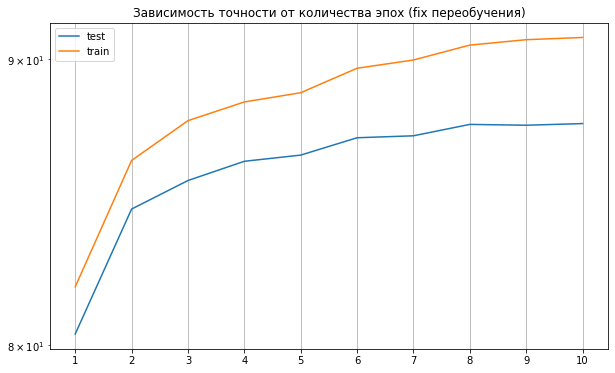

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_test, label='test')
plt.plot(range(1, epochs + 1), accuracy_train, label='train')
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.yscale('log')
plt.legend()
plt.title("Зависимость точности от количества эпох (fix переобучения)")
plt.grid()

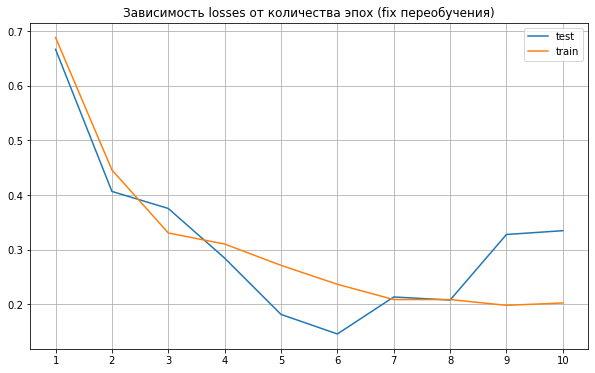

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses_test, label='test')
plt.plot(range(1, epochs + 1), losses_train, label='train')
plt.xticks(range(1, epochs + 1), range(1, epochs + 1))
plt.legend()
plt.title("Зависимость losses от количества эпох (fix переобучения)")
plt.grid()

Супер, мы справились с оверфиттингом - теперь качество на тесте растет примерно также, как и качество на трейне. Ура!

### Conclusions:
_Write down small report with your conclusions and your ideas._

Получили требуемое качество за 20 эпох: 88.79%, получилось также сделать оверфит модели и побороть его с помощью механизма DropOut.